In [1]:
!pip install transformers >> /dev/null
!pip install pyyaml==5.4.1 >> /dev/null

# Testing classifier

This script can be used to test the classifier against any file containing adversarial samples previously generated.

Important: exact results reported in the paper cannot be reproduced for datasets that contain more than 250 samples because we used a random sampling process to produce a static local test file. Then, all experiments used that file for faster execution and avoid repeated logits computation. However, this simplified code performs a tail sampling that won't retrieve the same sentences.

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import time
import importlib
from copy import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading and transforming data into logits differences

The first step is transforming our dataframe into logits differences for each original and adversarial sentence. For this, it is required to execute the model for each sentence with substitutions as explained in the paper.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SAMPLES_PATH = '/content/drive/MyDrive/AdversarialXAI/Adversarial Samples'
MODEL_PATH = '/content/drive/MyDrive/AdversarialXAI/Classifiers/WDR/agnews_classifier.pickle'

# Print available setups for testing
for i in os.listdir(SAMPLES_PATH):
    if not i.startswith('.'): # Don't print system files
        print(i)

ag-news_100_styleadv_distilbert.csv
ag-news_1000_styleadv_distilbert.csv
imdb_test_100_styleadv_distilbert.csv
imdb_train_200_styleadv_distilbert.csv
imdb_train_1000_styleadv_distilbert.csv
Older attacks
sst2_test_100_styleadv_distilbert.csv
sst2_train_2000_styleadv_distilbert.csv
sst2_val_100_styleadv_distilbert.csv
sst2_val_styleadv_distilbert.csv
sst2_pruthi_bert-base-uncased.csv


In [5]:
# Select the analysis configuration
test_config = 'sst2_pruthi_bert-base-uncased.csv'

In [7]:
# Obtain model from test config
model_arch = test_config.replace(".csv", "").split('_')[-1]
dataset = "SST-2" # test_config.split('_')[0]

model_arch = "bert"
print("Model architecture:", model_arch)
print("Dataset:", dataset)

Model architecture: bert
Dataset: SST-2


In [8]:
def load_textattack_local_model(model_arch, dataset):
    
    def load_module_from_file(file_path):
        """Uses ``importlib`` to dynamically open a file and load an object from
        it."""
        temp_module_name = f"temp_{time.time()}"

        spec = importlib.util.spec_from_file_location(temp_module_name, file_path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        return module
    
    m = load_module_from_file(f'../{model_arch}_textattack.py')
    model = getattr(m, 'model')
    
    return model, None    

In [9]:
def load_hugging_face_model(model_arch, dataset):
    # Import the model used for generating the adversarial samples.
    # Correctly, set up imports, model and tokenizer depending on the model you generated the samples on.
    
    if model_arch == 'distilbert':
        from transformers import DistilBertConfig as config, DistilBertTokenizer as tokenizer, AutoModelForSequenceClassification as auto_model
    elif model_arch == 'bert':
        from transformers import BertConfig as config, BertTokenizer as tokenizer, AutoModelForSequenceClassification as auto_model
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = tokenizer.from_pretrained(f"textattack/{model_arch}-base-uncased-{dataset}")
    model = auto_model.from_pretrained(f"textattack/{model_arch}-base-uncased-{dataset}").to(device)
    
    return model, tokenizer

In [10]:
# Models available in hugging-face are executed differently from LSTM and CNN. Choose automatically the configuration and load model + tokenizer.
textattack_local_models = ['lstm', 'cnn']

if model_arch in textattack_local_models:
    hugging_face_model = False
    model, tokenizer = load_textattack_local_model(model_arch, dataset)

else:
    hugging_face_model = True
    model, tokenizer = load_hugging_face_model(model_arch, dataset)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

# Loading data

Read into a dataframe your original and adversarial samples.

In [27]:
# Read the desired csv file previously generated
df = pd.read_csv(f'{SAMPLES_PATH}/{test_config}', index_col=False)

print(df.shape, df.columns)

(1821, 9) Index(['original_text', 'perturbed_text', 'original_score', 'perturbed_score',
       'original_output', 'perturbed_output', 'ground_truth_output',
       'num_queries', 'result_type'],
      dtype='object')


In [29]:
# ddf = df.query("p_val == 1")
# if 'adversarial_text' not in df.columns:
#   df = df.rename(columns={"perturbed_text": "adversarial_text"})

In [30]:
# Create batches of non-adversarial sentences
# For big models such as BERT, we must divide our input in smaller batches.
n = 256 # Size of each batch.
batches = [list(df.original_text.values)[i:i + n] for i in range(0, len(df.original_text.values), n)]

In [31]:
# Generate predictions for all non-adversarial sentences in our dataset
outputs = []

if hugging_face_model is True: # Use tokenizer and hugging face pipeline
    for b in batches: 
        input = tokenizer(b, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output = model(**input)
            outputs.append(output.logits.cpu().numpy())
            del input
            torch.cuda.empty_cache()

else: # Use local model by simply predicting without tokenization
    for b in batches: 
        output = model(b)
        outputs.append(output)

In [32]:
# Obtain non-adversarial predictions
outputs_flatten = [item for sublist in outputs for item in sublist]
predictions = [np.argmax(i) for i in outputs_flatten]

# Include prediction for these classes in our DataFrame
df['original_class_predicted'] = predictions

In [33]:
# Strip all null values from dataframe
df = df.fillna('')

# Repeat process for adversarial sentences
n = 256
batches = [list(df.adversarial_text.values)[i:i + n] for i in range(0, len(df.adversarial_text.values), n)]

In [34]:
# Generate predictions for all non-adversarial sentences in our dataset
outputs = []

if hugging_face_model is True: # Use tokenizer and hugging face pipeline
    for b in batches:
        input = tokenizer(b, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output = model(**input)
            outputs.append(output.logits.cpu().numpy())
            del input
            torch.cuda.empty_cache()

else: # Use local model by simply predicting without tokenization
    for b in batches: 
        output = model(b)
        outputs.append(output)

In [35]:
# Obtain adversarial predictions
outputs_flatten = [item for sublist in outputs for item in sublist]
predictions = [np.argmax(i) for i in outputs_flatten]

# Include prediction for these classes in our DataFrame
df['adversarial_class_predicted'] = predictions

In [36]:
df

,original_text,adversarial_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type,original_class_predicted,adversarial_class_predicted
0,"no movement , no yuks , not much of anything","no movement , no yuks , not muMch of anything",0.005266,0.017786,0.0,0.0,0.0,120.0,Failed,0,0
1,"a gob of drivel so sickly sweet , even the eag...","a gob of drivel so sifkly sweet , even the eag...",0.022394,0.218437,0.0,0.0,0.0,368.0,Failed,0,0
2,"gangs of new york is an unapologetic mess , wh...","gangs of new york is an unapologetic mezs , wh...",0.001128,0.004485,0.0,0.0,0.0,322.0,Failed,0,0
3,"we never really feel involved with the story ,...","we neevr really feel involved with the story ,...",0.001667,0.987937,0.0,1.0,0.0,253.0,Successful,0,1
4,this is one of polanski 's best films,this is one of polanski 's bst films,0.000644,0.986980,1.0,0.0,1.0,85.0,Successful,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1816,"an often deadly boring , strange reading of a ...","an often deadly bring , strange reading of a c...",0.005835,0.196575,0.0,0.0,0.0,457.0,Failed,0,0
1817,the problem with concept films is that if the ...,the probelm with concept films is that if the ...,0.002259,0.008497,0.0,0.0,0.0,184.0,Failed,0,0
1818,"safe conduct , however ambitious and well inte...","safe conduct , however ambitious and well inte...",0.006003,0.588392,0.0,1.0,0.0,343.0,Successful,0,1
1819,"a film made with as little wit , interest , an...","a film made with as litte wit , interest , and...",0.001025,0.971741,0.0,1.0,0.0,446.0,Successful,0,1


In [38]:
# Select only those sentences for which there was actually a change in the prediction
correct = df[(df['original_class_predicted'] != df['adversarial_class_predicted'])]
if "p_val" in df.columns:
  assert len(correct) == len(df.query("p_val == 1"))

In [39]:
# Update dataframe and keep only adversarial samples
df = correct

In [40]:
# df.head()
len(df)
df

,original_text,adversarial_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type,original_class_predicted,adversarial_class_predicted
3,"we never really feel involved with the story ,...","we neevr really feel involved with the story ,...",0.001667,0.987937,0.0,1.0,0.0,253.0,Successful,0,1
4,this is one of polanski 's best films,this is one of polanski 's bst films,0.000644,0.986980,1.0,0.0,1.0,85.0,Successful,1,0
6,"acting , particularly by tambor , almost makes...","acting , particularly by tambor , aljost makes...",0.095160,0.586214,0.0,1.0,0.0,501.0,Successful,0,1
7,the movie exists for its soccer action and its...,the movie exists for its soccer action and its...,0.000532,0.949870,1.0,0.0,1.0,152.0,Successful,1,0
8,arnold 's jump from little screen to big will ...,arnold 's jump from little screen to big will ...,0.039787,0.998977,0.0,1.0,0.0,171.0,Successful,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1812,lrb a rrb hollywood sheen bedevils the film fr...,lrb a rrb hollywood sheen bedevils the film fr...,0.004160,0.988022,1.0,0.0,1.0,403.0,Successful,1,0
1814,blade ii is more enjoyable than the original,blade ii is more ennoyable than the original,0.000648,0.691177,1.0,0.0,1.0,126.0,Successful,1,0
1818,"safe conduct , however ambitious and well inte...","safe conduct , however ambitious and well inte...",0.006003,0.588392,0.0,1.0,0.0,343.0,Successful,0,1
1819,"a film made with as little wit , interest , an...","a film made with as litte wit , interest , and...",0.001025,0.971741,0.0,1.0,0.0,446.0,Successful,0,1


# Obtain logits
Once we have the predictions and actually adversarial sentences, we generate the logits differences

In [41]:
# For large datasets we keep tail. Head is used for training. This way we ensure no intersection
if len(df) > 250:
    df = df.tail(250)

In [42]:
original_samples = df.original_text.values
adversarial_samples = df.adversarial_text.values

In [43]:
# Concatenate all original samples and their predictions
x = np.concatenate((original_samples, adversarial_samples))
y = np.concatenate((np.zeros(len(original_samples)), np.ones(len(adversarial_samples))))

In [44]:
def obtain_logits(samples, batch_size, model, tokenizer):
    """
    For given samples and model, compute prediction logits.
    Input data is splitted in batches.
    """
    batches = [samples[i:i + batch_size] for i in range(0, len(samples), batch_size)]
    logits = []

    for i, b in enumerate(batches):
        print("{}/{}".format(i+1, len(batches)))
        if hugging_face_model:
            with torch.no_grad():
                input = tokenizer(list(b), return_tensors="pt", padding=True, truncation=True).to(device)
                logits.append(model(**input).logits.cpu().numpy())
        else:
            logits.append(model(b))

    return logits

In [45]:
# Compute logits for original sentences
batch_size = 350
original_logits = obtain_logits(original_samples, batch_size, model, tokenizer)
original_logits = np.concatenate(original_logits).reshape(-1, original_logits[0].shape[1])

1/1


In [46]:
torch.cuda.empty_cache()

In [47]:
# Compute logits for adversarial sentences
batch_size = 350
adversarial_logits = obtain_logits(adversarial_samples, batch_size, model, tokenizer)
adversarial_logits = np.concatenate(adversarial_logits).reshape(-1, adversarial_logits[0].shape[1])

1/1


In [48]:
torch.cuda.empty_cache()

In [49]:
# Concatenate all logits
logits = np.concatenate((original_logits, adversarial_logits))

In [50]:
# Shuffle data
import random
c = list(zip(x, y, logits))
random.shuffle(c)
x, y, logits = zip(*c)

## Computing logits difference

This is a key step implemented. The main idea is:
* For each sentence, replace each word by the `[UNK]` token and compute prediction logits
* Using these logits, we can easily compute the saliency of the word as presented in the report.
* Then, we sort words by descending saliency.
* Finally, compute logits difference for each replacement. This difference is computed as `Logit from class predicted for the whole sentence - Highest remaining logit`

More details on these derivations are found in the paper.

In [51]:
def compute_logits_difference(x, logits, y, model, tokenizer, idx, max_sentence_size=512):
    n_classes = len(logits[idx])
    predicted_class = np.argmax(logits[idx]) # Predicted class for whole sentence using previously computed logits
    class_logit = logits[idx][predicted_class] # Store this origianl prediction logit

    split_sentence = x[idx].split(' ')[:max_sentence_size] # The tokenizer will only consider 512 words so we avoid computing innecessary logits

    new_sentences = []

    # Here, we replace each word by [UNK] and generate all sentences to consider
    for i, word in enumerate(split_sentence):
        new_sentence = copy(split_sentence)
        new_sentence[i] = '[UNK]'
        new_sentence = ' '.join(new_sentence)
        new_sentences.append(new_sentence)

    # We cannot run more than 350 predictions simultaneously because of resources.
    # Split in batches if necessary.
    # Compute logits for all replacements.
    if len(new_sentences) > 200:
        logits = []
        batches = [new_sentences[i:i + 200] for i in range(0, len(new_sentences), 200)]
        for b in batches:
            if hugging_face_model: # Use hugging face predictions
                batch = tokenizer(b, return_tensors="pt", padding=True, truncation=True).to(device)
                with torch.no_grad():
                    logits.append(model(**batch).logits)
            else:
                logits.append(model(b).to(device))
      
        if hugging_face_model:
            logits = torch.cat(logits)
        else:
            logits = np.concatenate( logits, axis=0 )
            logits = torch.Tensor(logits)
    
    else: # There's no need to split in batches
        if hugging_face_model:
            batch = tokenizer(new_sentences, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                logits = model(**batch).logits
            del batch
        else:
            logits = model(new_sentences)
            logits = torch.Tensor(logits)


    # Compute saliency
    saliency = (class_logit - logits[:,predicted_class]).reshape(-1, 1)

    # Append to logits for sorting
    data = torch.cat((logits, saliency), 1)

    # Sort by descending saliency
    data = torch.stack(sorted(data, key=lambda a: a[n_classes], reverse=True))

    # Remove saliency
    data = data[:, :n_classes]

    # Fix order: originallly predicted class, other classes
    order = [predicted_class] + [i for i in range(n_classes) if i!=predicted_class]
    data = torch.index_select(data, 1, torch.LongTensor(order).to(device))

    # Compute difference between predicted class (always first column) and higher remaining logit
    data = data[:, :1].flatten() - torch.max(data[:, 1:], dim=1).values.flatten()

    del saliency
    torch.cuda.empty_cache()

    # Return only logits difference
    return data.reshape(-1, 1), torch.Tensor([y[idx]]).to(device)

In [52]:
def compute_logits_difference_padding(x, logits, y, model, tokenizer, idx, target_size=512):
    """
    This function provides a wrapper for compute_logits_difference and includes padding to computations.
    """
    data, y = compute_logits_difference(x, logits, y, model, tokenizer, idx, target_size)
    data_size = min(512, data.shape[0])
    target = torch.zeros(target_size, 1).to(device)
    target[:data_size, :] = data

    return target, y

In [53]:
from torch.utils.data import Dataset, DataLoader
import sys
from torch.autograd import Variable

class Text(Dataset):
    """
    Dataloader following torch details. Each time we get an item, we will compute
    the logits difference.
    """
    def __init__(self, x , logits, y, model, tokenizer, train=True, max_sentence_size=512):
        self.logits = logits
        self.y = y
        self.x = x
        self.model = model
        self.tokenizer = tokenizer
        self.max_sentence_size = max_sentence_size

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        data, y = compute_logits_difference_padding(self.x, self.logits, self.y, self.model, self.tokenizer, idx, self.max_sentence_size)
        data = data[:, :1].unsqueeze(0)

        return data, y, self.x[idx]

In [54]:
# Create the dataloader
train_ds = Text(x, logits, y, model, tokenizer)
train_loader = DataLoader(dataset=train_ds, batch_size=256, shuffle=True)

In [55]:
# Define the target DataFrame to structure our data.
# It has a column for each input dimension (up to 512) and 
# it also includes whether it is adversarial or not (y_label) and the sentence from which the logits where extracted

data_test = pd.DataFrame(columns=[i for i in range(512)]+['y_label', 'sentence'])

In [56]:
# Generate logits difference by running the loader.
for i, (data, y_label, sentence) in enumerate(train_loader):
    print("{}/{} - {}\n".format(i, len(train_loader), i/len(train_loader)))
    for v in range(len(data)):
        # Structure data and include in dataframe
        row = np.append(data[v].cpu().numpy().reshape(1,-1), np.array([y_label[v].item(), sentence[v]]))
        data_test = data_test.append(pd.DataFrame([row], columns=list(data_test)), ignore_index=True)

0/2 - 0.0

1/2 - 0.5



# Perform test
Use logits differences to execute the classifier

In [57]:
y_test = data_test['y_label'].astype(float).values
x_test = data_test.drop(columns=['y_label', 'sentence']).values

In [58]:
x_test

array([['2.4774957', '3.1422303', '4.172214', ..., '0.0', '0.0', '0.0'],
       ['1.158636', '6.1092725', '6.3706994', ..., '0.0', '0.0', '0.0'],
       ['-0.21594009', '5.737946', '6.2402472', ..., '0.0', '0.0', '0.0'],
       ...,
       ['2.2137723', '3.1778932', '3.7834954', ..., '0.0', '0.0', '0.0'],
       ['-1.0583954', '-0.9948504', '0.22546539', ..., '0.0', '0.0',
        '0.0'],
       ['-1.9010477', '-1.2888677', '-1.1362349', ..., '0.0', '0.0',
        '0.0']], dtype=object)

In [59]:
data_test['sentence'].head(5)

0    a great comedy filmmaker knows great comedy ne...
1    legendary irish writer brendan behan 's memoir...
2                           i hated every minute of it
3                  does n't amoint to much of anything
4    a swewt natured reconsideration of one of san ...
Name: sentence, dtype: object

# Model and prediction

Load model and make predictions

In [60]:
import pickle

model = pickle.load(open(MODEL_PATH, "rb"))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [61]:
predictions_raw = model.predict_proba(x_test)

In [62]:
predictions_raw[:3]

array([[0.99699   , 0.00300998],
       [0.99175566, 0.00824432],
       [0.92228454, 0.07771547]], dtype=float32)

In [63]:
predictions_raw = predictions_raw[:,1]

In [64]:
predictions = predictions_raw.round()

In [65]:
data_test['y_hat'] = predictions
data_test['y_prob'] = predictions_raw
data_test['y'] = y_test

# Metrics and errors

Analyze the results

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[198,  52],
       [124, 126]])

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

         0.0      0.615     0.792     0.692       250
         1.0      0.708     0.504     0.589       250

    accuracy                          0.648       500
   macro avg      0.661     0.648     0.641       500
weighted avg      0.661     0.648     0.641       500



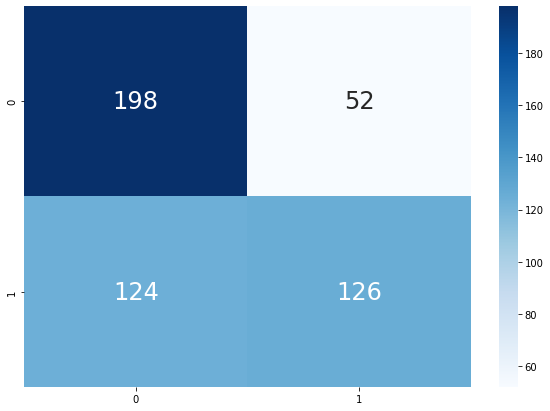

In [68]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

# Shifting cutoff

We tried different values for the decision cutoff value to see whether we could further increase adversarial recall.

In [69]:
new_y_hat = np.where(predictions_raw>0.4, 1, 0)

In [70]:
new_y_hat[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

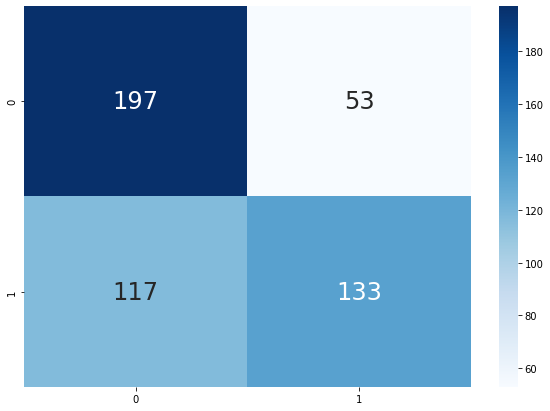

In [71]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, new_y_hat), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.627     0.788     0.699       250
         1.0      0.715     0.532     0.610       250

    accuracy                          0.660       500
   macro avg      0.671     0.660     0.654       500
weighted avg      0.671     0.660     0.654       500



### 0.3

In [73]:
new_y_hat = np.where(predictions_raw>0.3, 1, 0)

In [74]:
new_y_hat[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

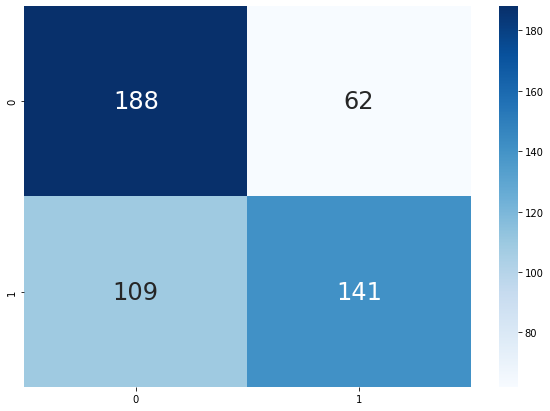

In [75]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, new_y_hat), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.633     0.752     0.687       250
         1.0      0.695     0.564     0.623       250

    accuracy                          0.658       500
   macro avg      0.664     0.658     0.655       500
weighted avg      0.664     0.658     0.655       500



### 0.15

In [77]:
new_y_hat = np.where(predictions_raw>0.15, 1, 0)

In [78]:
new_y_hat[:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1])

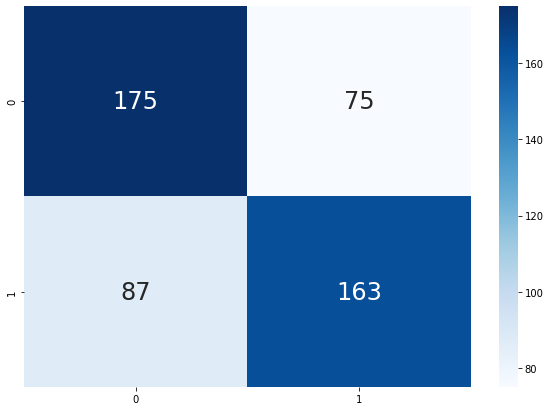

In [79]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, new_y_hat), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.668     0.700     0.684       250
         1.0      0.685     0.652     0.668       250

    accuracy                          0.676       500
   macro avg      0.676     0.676     0.676       500
weighted avg      0.676     0.676     0.676       500



# Density chart

In [63]:
import plotly.figure_factory as ff
import numpy as np

# Plot the probability density chart
probability_dens = pd.DataFrame({'prob': predictions_raw, 'y': y_test})

x1 = probability_dens[probability_dens["y"]==1]['prob'].values
x2 = probability_dens[probability_dens["y"]==0]['prob'].values

hist_data = [x1, x2]

group_labels = ['Adversarial', 'Original']
colors = ['#C04000', '#228B22']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors, show_rug=False)

# Add title
fig.update_layout(legend=dict(
                    orientation="h",
                    yanchor="middle",
                    y=1.1,
                    xanchor="right",
                    x=1
                ))

fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
